$$
\newcommand{\fudm}[2]{\frac{\mathrm{D} #1}{\mathrm{D} #2}}
\newcommand{\pad}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\ppad}[2]{\frac{\partial^2 #1}{\partial #2^2}}
\newcommand{\ppadd}[3]{\frac{\partial^2 #1}{\partial #2 \partial #3}}
\newcommand{\nnabla}{\nabla^2}
\newcommand{\eps}{\epsilon}
\newcommand{\vdetail}[1]{\vb{#1}=\begin{pmatrix}#1_1\\#1_2\\#1_3\end{pmatrix}}
\newcommand{\vb}[1]{\mathbf{#1}}
\newcommand{\va}[1]{\vec{#1}}
\newcommand{\tb}[1]{\underline{\underline{\mathbf{#1}}}}
\newcommand{\fud}[2]{\frac{\mathrm{d} #1}{\mathrm{d} #2}}
$$

# Volume of Fluid Solver

This IPython Notebook follows the [Tutorial](../Documents/FOV_Tryggvason_DNS-Solver.pdf) from Prof Gretar Tryggvason (A Front-tracking/Finite-Volume Navier-Stokes Solver for Direct Numerical Simulations of Multiphase Flows).

Here we will develop a fluid solver using the volume of fluid (VOF) method for a simple multiphase flow. Multiphase flows are flows consisting of multiple phases, i.e. different densities and viscosities. They may also have an interfacial tension between the phases. We will write a 2-dimensional incompressible VOF solver for two phases. Initially we allow only for a difference in density.

The Navier Stokes equations to solve are

$$\rho \pad{\vb{u}}{t}+\rho (\nabla \cdot \vb{u})\vb{u}=-\nabla p +\rho \vb{g} +\mu_0\nabla^2\vb{u}\quad .\tag{1}$$

The viscosity of both phases of the fluid is $\mu_0$. Please note that we now include gravity as a body force. Additionally we require incompressibility:

$$\nabla\cdot\vb{u}=0\tag{2}$$

Besides the VOF method the present approach makes use of number of improvements/changes as compared to our previous pressure/velocity formulation. In particular we use a different grid where the two velocity, pressures are evaluated.

## Integration in time

The time integration is done by a two-step calculation, first the velocity field is calculated ignoring the pressure and then the pressure is added. This is similar to the previous velocity-pressure formulation, yet now we separate the discrete operators for advection $\vb{A}$ and diffusion $\vb{D}$.

<a name="eq3"></a>
$$\frac{\vb{u}^*-\vb{u}^n}{\Delta t}=-\vb{A}^n+\vb{g}^n+\frac{1}{\rho^n}\vb{D}^n\tag{3}$$

The pressure is introduced in a second step

<a name="eq4"></a>
$$\frac{\vb{u}^{n+1}-\vb{u}^*}{\Delta t}=-\frac{\nabla_h p}{\rho^n}\quad .\tag{4}$$

$\nabla_h$ is the discrete operator for the gradient. If you add above two equations [Eqs. (3) and (4)](#eq3) you obtain a discrete form of the N.S. equations. The pressure needs to be obtained in such a way that the final velocity field is divergent free, $\nabla_h\cdot\vb{u}^{n+1}=0$. 
The equation to calculate an appropriate pressure field is obtained by taking the divergent of [Eq. (4)](#eq4) and accounting for the divergent free velocity field $\vb{u}^{n+1}$.

$$\nabla_h\cdot\left(\frac{1}{\rho^n}\nabla_h p\right)=\frac{1}{\Delta t}\nabla_h\cdot\vb{u}^*\tag{5}$$

## VOF discretization
The conservation principles in the VOF method are applied on small control volumes. The physical quantities are averaged over the volume, e.g. the average velocity in a controll volume is 

$$ \vb{u}=\frac{1}{V}\int_V \vb{u}(\vb{x})\,dV\quad.\tag{6}$$

The same holds for the advection operator $\vb{A}$.

$$ \vb{A}=\frac{1}{\rho}\int_V(\nabla\cdot\vb{u})\vb{u}\,dV=
\frac{1}{V}\oint_S (\vb{u}\cdot\vb{n})\vb{u}\,dS\tag{7}$$

We have used Gauss theorem to transform the volume into surface integrals.
The diffusion operator $\vb{D}$ transforms similarily:

$$\vb{D}=\frac{\mu_0}{V}\int_V \nabla^2 \vb{u} \, dV=
\frac{\mu_0}{V}\int_V \nabla\cdot\nabla \vb{u} \, dV=
\frac{\mu_0}{V}\oint_S \nabla \vb{u}\cdot\vb{n} \, dS\tag{7}$$

The incompressibility condition transforms as

$$\frac{1}{V}\int_V \nabla \cdot \vb{u} \,dV=\frac{1}{V}\oint_S \vb{n} \cdot \vb{u} \,dS\quad .\tag{8}$$

At last we need to integrate the gradient of the pressure over the volume/surface:

$$\nabla_h p =\frac{1}{V} \int_V \nabla p \,dV = \frac{1}{V}\oint_S \vb{n} p\, dS\quad .\tag{9}$$ 

## Grids
<img src="../pics/staggered grid_3.png" width=450> <p>
<center> Figure 1 </center>

For the VOF method we will use a different mesh than we have used in the finite difference method. The The integrals mentioned above will be evaluated in a control volume $\Delta V=\Delta x \Delta y$ or on the surface of the volume which is centered at position $(i,j)$. The control volume is shaded yellow and has a red boundary. Let's evaluate the surface integral 

$$\frac{1}{V}\oint_S \vb{n} \cdot \vb{u} \,dS\tag{10}$$

of the control volume. Using the midpoint rule for evaluating the surface integrals we obtain:

<a name="eq11"></a>
$$\Delta y \left(u_{i+1/2,j}-u_{i-1/2,j}\right)+\Delta x \left(v_{i,j+1/2}-v_{i,j-1/2}\right)=0\tag{11}$$

With this grid we need the horizontal velocities $u$ only to be defined at the midpoints of vertical edges and the vertical velocities $v$ at the midpoints of the horizontal edges of the control volume. This fact is sketched in the figure below. 

<img src="../pics/staggered grid_2.png" width=450> <p>
<center> Figure 2 </center>

The pressure, density and other scaler quantities are specified at the gridpoint $(i,j)$ while the $u$-velocity component is referenzed at $(i+1/2,j)$ and the vertical velocity component at $(i,j+1/2)$. The reason for this staggering of the grid will come clear in a short while.

Note: In 2 dimensions the volumes are actually areas and the surfaces lines, yet using this terminology makes it easier to formulate the 3d problem at a later stage.


## Schemes
Let's start with the difference schemes, the first is that for the predicted/temporary velocity $\vb{u}^*$

$$\vb{u}^*=\vb{u}^n+\Delta t\left(-\vb{A}^n+\vb{g}^n+\frac{1}{\rho^n}\vb{D}^n\right)\tag{12}$$

We write it for the horizontal temporary velocity component

$$u^*_{i+1/2,j}=u^n_{i+1/2,j}+\Delta t\left( (-A_x)^n_{i+1/2,j}+(g_x)^n_{i+1/2,j}+
\frac{1}{\frac{1}{2}\left(\rho^n_{i+1,j}+\rho^n_{i,j}\right)}(D_x)^n_{i+1/2,j}\right)\tag{13}$$

and for the vertical temporary velocity component:

$$u^*_{i,j+1/2}=v^n_{i,j+1/2}+\Delta t\left( (-A_y)^n_{i,j+1/2}+(g_y)^n_{i,j+1/2}+
\frac{1}{\frac{1}{2}\left(\rho^n_{i,j+1}+\rho^n_{i,j}\right)}(D_y)^n_{i,j+1/2}\right)\tag{14}$$

Here the density $\rho$ is not available at positions $(i+1/2,j)$ and $(i,j+1/2)$. This value is extrapolated from the neighboring cells, e.g. $\rho_{i+1/2,j}=\frac{1}{2}(\rho_{i,j}+\rho_{i+1,j})$.

Once having obtained the temporary velocity and the pressure field we can calculate the velocity at the next time step. This leads to the discretized equations using spatial forward differences:

<a name="eq15"></a>
$$u^{n+1}_{i+1/2,j}=u^*_{i+1/2,j}-\frac{\Delta t}{\frac{1}{2}\left(\rho^n_{i+1,j}+\rho^n_{i,j}\right)} \frac{p_{i+1,j}-p_{i,j}}{\Delta x}\tag{15}$$

and 

<a name="eq16"></a>
$$v^{n+1}_{i,j+1/2}=v^*_{i,j+1/2}-\frac{\Delta t}{\frac{1}{2}\left(\rho^n_{i,j+1}+\rho^n_{i,j}\right)} \frac{p_{i,j+1}-p_{i,j}}{\Delta y}\tag{16}$$




## Advection Operator
Next we discretize the advection operator $\vb{A}$.We first formulate the discretization for the position $(i+1/2,j)$, e.g. a box as shown below.

<img src="../pics/staggered grid_4.png" width=450> <p>
<center> Figure 3 </center>

The advection operator in integral form is $\vb{A}=\frac{1}{V}\oint_S (\vb{u}\cdot\vb{n})\vb{u}\,dS$. 

$$(A_x)_{i+1/2,j}=\frac{1}{\Delta x\Delta y}\left(\left[(uu)_{i+1,j}-(uu)_{i,j}\right]\Delta y+\\
\left[(uv)_{i+1/2,j+1/2}-(uv)_{i+1/2,j-1/2}\right]\Delta x\right)\tag{17}
$$

Please check above formula yourself using the correct orientation of the normal vector $\vb{n}$. The expression $uu$ stands for $u^2$ but to avoid the upper index not to confuse with time. Similarily the advection operator in $y$-direction can be formulated:

$$(A_y)_{i+1/2,j}=\frac{1}{\Delta x\Delta y}\left(\left[(uv)_{i+1/2,j+1/2}-(uv)_{i-1/2,j+1/2}\right]\Delta y+\\
\left[(vv)_{i,j+1}-(vv)_{i,j}\right]\Delta x\right)\tag{18}
$$

Unfortunately, above schemes are not useable on the staggered grids as we would need velocities $u$, $v$ on integer grid points. These can however be approximated from linear interpolation. For example $(uu)_{i+1,j}$ is approximated as $(\frac{1}{2}(u_{i+3/2,j}+u_{i+1/2,j}))^2$. The $(A_x)^n_{i+1/2,j}$ in its whole beauty is:

$$
(A_x)^n_{i+1/2,j}=\frac{1}{\Delta x} \left[
\left(\frac{u^n_{i+3/2,j}+u^n_{i+1/2,j}}{2}\right)^2-
\left(\frac{u^n_{i+1/2,j}+u^n_{i-1/2,j}}{2}\right)^2\right]\\
+\frac{1}{\Delta y} \left[
\left(\frac{u^n_{i+1/2,j+1}+u^n_{i+1/2,j}}{2}\right)
\left(\frac{v^n_{i+1,j+1/2}+v^n_{i,j+1/2}}{2}\right)\\
-\left(\frac{u^n_{i+1/2,j}+u^n_{i+1/2,j-1}}{2}\right)
\left(\frac{v^n_{i+1,j-1/2}+v^n_{i,j-1/2}}{2} \right)\right]\tag{19}
$$
and the $y$-component:
$$
(A_y)^n_{i,j+1/2}=\frac{1}{\Delta x} \left[
\left(\frac{u^n_{i+1/2,j}+u^n_{i+1/2,j+1}}{2}\right)
\left(\frac{v^n_{i,j+1/2}+v^n_{i+1,j+1/2}}{2}\right)\\
-\left(\frac{u^n_{i-1/2,j+1}+u^n_{i-1/2,j}}{2}\right)\left(\frac{v^n_{i,j+1/2}+v^n_{i-1,j+1/2}}{2}\right)\right]\\
+\frac{1}{\Delta y} \left[
\left(\frac{v^n_{i,j+3/2}+v^n_{i,j+1/2}}{2}\right)^2
-\left(\frac{v^n_{i,j+1/2}+v^n_{i,j-1/2}}{2}\right)^2\right]\quad .\tag{20}
$$



## Diffusion Operator

The Diffusion operator is $\vb{D}=\frac{\mu_0}{V}\oint_S (\nabla \vb{u}) \vb{n} dS$. Thus we have to discretize the product of the velocity gradient tensor and the normal vector. In 2 dimensions the kernel of this integral is

$$\begin{pmatrix}
\pad{u}{x} n_x + \pad{u}{y} n_y\\
\pad{v}{x} n_x + \pad{v}{y} n_y
\end{pmatrix}\tag{21}
$$

The $x$-component of the diffusion operator has to be evaluated at position $(i+1/2,j)$. We first write it assuming that we do know the values of the velocity gradient tensor at all points. In a second step we replace all the points we don't know with linear interpolated values. Let's have first a look at the picture of the finite volume and the orientation of the normal vectors.

<img src="../pics/staggered grid_5.png" width=450> <p>
<center> Figure 4 </center>


$$(D_x)^n_{i+1/2,j}=\frac{\mu_0}{\Delta x\Delta y}\left[\left(\left.\pad{u}{x}\right|_{i+1,j}-\left.\pad{u}{x}\right|_{i,j}\right)\Delta y+\\
\left(\left.\pad{u}{y}\right|_{i+1/2,j+1/2}-\left.\pad{u}{y}\right|_{i+1/2,j-1/2}\right)\Delta x\right]\tag{22}$$


The diffusion operator in the $y$-direction is centered at $(i,j+1/2)$, therefore a different VOF cell has to be used:

$$(D_y)^n_{i,j+1/2}=\frac{\mu_0}{\Delta x\Delta y}\left[\left(\left.\pad{v}{x}\right|_{i+1/2,j+1/2}-\left.\pad{v}{x}\right|_{i-1/2,j+1/2}\right)\Delta y+\\
\left(\left.\pad{v}{y}\right|_{i,j+1}-\left.\pad{v}{y}\right|_{i,j}\right)\Delta x\right]\quad .\tag{23}$$

The velocity derivatives are obtained from second order derivatives, e.g. $\pad{u}{x}(i,j)=(u_{i+1/2,j}-u_{i-1/2,j})/\Delta x$.

$$(D_x)^n_{i+1/2,j}=\mu_0\left[\left(\frac{u^n_{i+3/2,j}-2u^n_{i+1/2,j}+u^n_{i-1/2,j}}{\Delta x^2}\right)+\\
\left(\frac{u^n_{i+1/2,j+1}-2u^n_{i+1/2,j}+u^n_{i+1/2,j-1}}{\Delta y^2}\right)\right]\tag{24}$$

$$(D_y)^n_{i,j+1/2}=\mu_0\left[\left(\frac{v^n_{j+1,j+1/2}-2v^n_{i,j+1/2}+v^n_{i-1,j+1/2}}{\Delta x^2}\right)+\\
\left(\frac{v^n_{i,j+3/2}-2v^n_{i,j+1/2}+v^n_{i,j-1/2}}{\Delta y^2}\right)\right]\tag{25}$$

Here we have assumed a constant viscosity over the whole fluid domain. For fluids with varying density and viscosity the stress tensor needs to be rewritten and the present diffusion operator becomes invalid. We'll discuss this modification in the following notebooks.


## The Pressure Equation
A finite difference equation for the pressure can be obtained from [Eq. (11)](#eq11) for the velocity components $u^{n+1}$ and $v^{n+1}$. We insert into [Eq. (11)](#eq11) the [Eqs. (15)](#eq15) and [(16)](#eq16) and similar equations for $u^{n+1}_{i-1/2,j}$ and $v^{n+1}_{i,j-1/2}$. 

<a name="eq26"></a>
$$\frac{1}{\Delta x}\left[u^*_{i+1/2,j}-\frac{\Delta t}{\frac{1}{2}\left(\rho^n_{i+1,j}+\rho^n_{i,j}\right)}
\left(\frac{p_{i+1,j}-p_{i,j}}{\Delta x}\right)
-u^*_{i-1/2,j}+\frac{\Delta t}{\frac{1}{2}\left(\rho^n_{i,j}+\rho^n_{i-1,j}\right)}
\left(\frac{p_{i,j}-p_{i-1,j}}{\Delta x}\right)\right]\\
+\frac{1}{\Delta y}\left[v^*_{i,j+1/2}-\frac{\Delta t}{\frac{1}{2}\left(\rho^n_{i,j+1}+\rho^n_{i,j}\right)}
\left(\frac{p_{i,j+1}-p_{i,j}}{\Delta y}\right)
-v^*_{i,j-1/2}+\frac{\Delta t}{\frac{1}{2}\left(\rho^n_{i,j}+\rho^n_{i,j-1}\right)}
\left(\frac{p_{i,j}-p_{i,j-1}}{\Delta y}\right)\right]=0\tag{26}$$

Multiplying [Eq. (26)](#eq26) with $-\Delta x\,\Delta y (2\Delta t)^{-1}$ leads to 

<a name="eq27"></a>
$$ \frac{1}{2\Delta t}\left[\frac{u^*_{i+1/2,j}-u^*_{i-1/2,j}}{\Delta x}+\frac{v^*_{i,j+1/2}-v^*_{i,j-1/2}}{\Delta y}\right]=\\
\frac{1}{\Delta x^2}\left(\frac{p_{i+1,j}-p_{i,j}}{\rho^n_{i+1,j}+\rho^n_{i,j}}-\frac{p_{i,j}-p_{i-1,j}}{\rho^n_{i,j}+\rho^n_{i-1,j}}\right)+\frac{1}{\Delta y^2}\left(\frac{p_{i,j+1}-p_{i,j}}{\rho^n_{i,j+1}+\rho^n_{i,j}}-\frac{p_{i,j}-p_{i,j-1}}{\rho^n_{i,j}+\rho^n_{i,j-1}}\right)
\tag{27}$$

The pressure equation can be solved Jacobian, SOR or similar techniques.

## Computational Grid
The grid covers a rectangle of size $L_x$ and $L_y$ devided into $N_x$ and $N_y$ volumes for the pressure. We therefore would need arrays of size $(N_x, N_y)$ for the presssure $p$, and $(N_x+1,N_y)$ for the horizontal velocity $u$ and $(N_x,N_y+1)$ for the vertical velocity $v$. 

However, for implementing boundary conditions we need one additional cell past the boundary for the wall tangential velocity, that means with 2 boundaries in the horizontal and vertical the shape of the $u$ array is $(N_x+1,N_y+2)$ and for $v$ array is $(N_x+2,N_y+1)$. The pressure is defined in the center of each cell, and as we have now 2 more cells in each direction we need $(N_x+2,N_y+2)$ cells for $p$. We'll see below that we don't need to calculate pressure values for these ghost cells; they will be set to 0. The figure below shows a 5-element square grid. The boundaries are marked in red.

<a name="fig5"></a><img src="../pics/staggered grid_complete.png" width=650> <p>
<center> Figure 5 </center>


## Boundary Conditions

Now we experience a downside and an advantage from the staggered grid approach. Although the staggered grid allows simple definition of the wall normal velocities, wall tangential velocties need some extra care. 

### Wall normal velocities
Wall normal velocities, i.e. $u$ for vertical walls and $v$ for horizontal wall coincide with the boundaries, see [Fig. 5](#fig5). Let the wall normal velocity on the left verical wall be $U_{b,j}$ then we simply set the velocity in the algorithm, see [Fig. 6](#fig6).


<a name="fig6"></a><a name="fig6"></a><img src="../pics/boundary_condition.png" width=350> <p>
<center> Figure 6 </center>

### Wall tangential velocities

However the tangential velocities can't be defined on the boundary; the grid is half a cell width away. We implement ghost cells for the tangential velocities (and pressures too). The ghost cell number is $1$, thus the first cell in the fluid is 2. Assuming a linear interpolation of the tangential velocity on the boundary

$$v_{wall}=\frac{1}{2}(v_{1,j+1/2}+v_{2,j+1/2})\quad.\tag{28}$$

The $v_{1,j+1/2}$ is the velocity on the ghost cells. Knowing the tangential velocity on the wall $v_{wall}$ we can define the velocity of the ghost cells:

$$v_{1,j+1/2}=2 \, v_{wall} - v_{2,j+1/2}\tag{29}$$

and in particular if the wall velocity is $v_{wall}=0$ we have

$$v_{1,j+1/2}=- v_{2,j+1/2}\tag{30}\quad.$$

To account for the tangential velocities for the remaining 3 boundaries similar expressions can be obtained.


Next we have a look at the pressure equation at the boundary

### Pressure at the boundary

For the situation shown in Fig. 6 we can again derive the pressure equation by starting with the $\nabla\cdot\vb{u}^{n+1}=0$ which now states

$$\frac{u^{n+1}_{i+1/2,j}-U_{b,j}}{\Delta x} + \frac{v^{n+1}_{i,j+1/2}-v^{n+1}_{i,j-1/2}}{\Delta y}=0\quad.\tag{30}$$

Inserting the expressions for the corrected velocity [Eqs. (15)](#eq15) and [(16)](#eq16) and similar equation for $v^{n+1}_{i,j-1/2}$ we obtain Eq. (31a). 

<a name="eq31"></a>
\begin{eqnarray}
\frac{1}{2\Delta t}\left[\frac{u^*_{i+1/2,j}-U_{b,j}}{\Delta x}+\frac{v^*_{i,j+1/2}-v^*_{i,j-1/2}}{\Delta y}\right]&=&\\
\frac{1}{\Delta x^2}\left(\frac{p_{i+1,j}-p_{i,j}}{\rho^n_{i+1,j}+\rho^n_{i,j}}\right)+\frac{1}{\Delta y^2}\left(\frac{p_{i,j+1}-p_{i,j}}{\rho^n_{i,j+1}+\rho^n_{i,j}}-\frac{p_{i,j}-p_{i,j-1}}{\rho^n_{i,j}+\rho^n_{i,j-1}}\right)
\tag{31a}\\
\frac{1}{2\Delta t}\left[\frac{u^*_{i+1/2,j}-u^*_{i-1/2,j}}{\Delta x}+\frac{v^*_{i,j+1/2}-v^*_{i,j-1/2}}{\Delta y}\right]&=&\\
\frac{1}{\Delta x^2}\left(\frac{p_{i+1,j}-p_{i,j}}{\rho^n_{i+1,j}+\rho^n_{i,j}}-\frac{p_{i,j}-p_{i-1,j}}{\rho^n_{i,j}+\rho^n_{i-1,j}}\right)+\frac{1}{\Delta y^2}\left(\frac{p_{i,j+1}-p_{i,j}}{\rho^n_{i,j+1}+\rho^n_{i,j}}-\frac{p_{i,j}-p_{i,j-1}}{\rho^n_{i,j}+\rho^n_{i,j-1}}\right)\tag{31b}
\end{eqnarray}

Equation (31b) is the pressure equation we obtained previously, i.e. [Eq. (27)](#eq27). Looking at Eq. (31a) we see that we do not need pressure values left of the boundary, i.e. $p_{i-1,j}$. So why have we previously announced that we use the pressure next to the boundaries? By comparing Eq. (31a) with Eq. (31b) we see that both equations are very similar, except for the second pressure time on the R.H.S. . This term can be forced to zero if we assume a very high density $\rho_{i-1,j}$ while keeping the pressure $p_{i-1,j}$ finite. In the numerical scheme this is done by setting the density to a high value and setting the pressure at $p_{i-1,j}=0$. Then we don't need to use different equations to solve at the boundaries. Ok, this holds only on the left boundary but similar relations can be obtained, all lead to the conditions, that the wall normal velocity is used together high densities and zero pressure in the ghost cells.

## Cavity-Lid problem

Below you find an example code for the cavity lid problem using above introduced schemes.

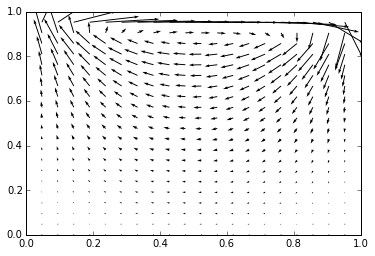

99


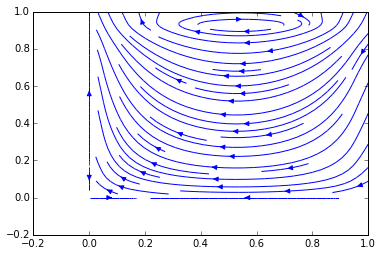

In [1]:
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
%matplotlib inline

#domain size and physical variables
Lx=1.0
Ly=1.0
gx=0.0
gy=0.0
rho1=1.0

#dynamic viscosity
m0=0.05

#tangential velocities
unorth=2.
usouth=0.
veast=0.
vwest=0.

#Numerical variables
nx=21
ny=21
dt=0.0004
nstep=100
maxiter=1000
maxError=0.001
beta=1.2

u=np.zeros((nx+1,ny+2))
v=np.zeros((nx+2,ny+1))
p=np.zeros((nx+2,ny+2))

ut=np.zeros((nx+1,ny+2))
vt=np.zeros((nx+2,ny+1))

#temp variables for pressure calculations
tmp1=np.zeros((nx+2,ny+2))
tmp2=np.zeros((nx+2,ny+2))

#velocities at center of grid for plotting
uu=np.zeros((nx+1,ny+1))
vv=np.zeros((nx+1,ny+1))
x = np.linspace(0.,Lx,nx)
y = np.linspace(0.,Ly,ny)

#Define the grid
dx=Lx/(nx) 
dy=Ly/(ny)


r=np.ones((nx+2,ny+2))*rho1
            
time=0.
for steps in range(nstep):
    
    #tangential velocity at boundaries
    u[:,0]=2.*usouth-u[:,1]
    u[:,-1]=2.*unorth-u[:,-2]
    v[0,:]=2.*vwest-v[1,:]
    v[-1,:]=2.*veast-v[-2,:]
    
    # TEMPORARY u-velocity                               
    for i in range(1,nx):
        for j in range(1,ny+1):
            ut[i,j]=u[i,j]+dt*(-0.25*(((u[i+1,j]+u[i,j])**2-(u[i,j]+\
                u[i-1,j])**2)/dx+((u[i,j+1]+u[i,j])*(v[i+1,j]+\
                v[i,j])-(u[i,j]+u[i,j-1])*(v[i+1,j-1]+v[i,j-1]))/dy)+\
                m0/(0.5*(r[i+1,j]+r[i,j]))*((u[i+1,j]-2*u[i,j]+u[i-1,j])/dx**2+\
                (u[i,j+1]-2*u[i,j]+u[i,j-1])/dy**2 )+gx)

    # TEMPORARY v-velocity                               
    for i in range(1,nx+1):
        for j in range(1,ny):
            vt[i,j]=v[i,j]+dt*(-0.25*(((u[i,j+1]+u[i,j])*(v[i+1,j]+\
                v[i,j])-(u[i-1,j+1]+u[i-1,j])*(v[i,j]+v[i-1,j]))/dx+\
                ((v[i,j+1]+v[i,j])**2-(v[i,j]+v[i,j-1])**2)/dy)+\
                m0/(0.5*(r[i,j+1]+r[i,j]))*((v[i+1,j]-2*v[i,j]+v[i-1,j])/dx**2+\
                (v[i,j+1]-2*v[i,j]+v[i,j-1])/dy**2 )+gy)    
    
    #Compute source term and the coefficient for p(i,j)
    rt=r.copy()
    lrg=1000.
    rt[:,0]=lrg
    rt[:,-1]=lrg
    rt[0,:]=lrg
    rt[-1,:]=lrg
    
    for i in range(1,nx+1):
        for j in range(1,ny+1):
            tmp1[i,j]= (0.5/dt)*( (ut[i,j]-ut[i-1,j])/dx+(vt[i,j]-vt[i,j-1])/dy)
            tmp2[i,j]=1.0/( (1./dx)*( 1./(dx*(rt[i+1,j]+rt[i,j]))+\
                1./(dx*(rt[i-1,j]+rt[i,j])))+\
                (1./dy)*(1./(dy*(rt[i,j+1]+rt[i,j]))+\
                1./(dy*(rt[i,j-1]+rt[i,j])))) 

    iter=0
    while True:
        pn=p.copy()
        iter=iter+1
        for i in range(1,nx+1):
            for j in range(1,ny+1):
                p[i,j]=(1.0-beta)*p[i,j]+beta*tmp2[i,j]*(\
                    (1./dx)*( p[i+1,j]/(dx*(rt[i+1,j]+rt[i,j]))+\
                    p[i-1,j]/(dx*(rt[i-1,j]+rt[i,j])))+\
                    (1./dy)*( p[i,j+1]/(dy*(rt[i,j+1]+rt[i,j]))+\
                    p[i,j-1]/(dy*(rt[i,j-1]+rt[i,j])))-tmp1[i,j])
        if np.abs(pn-p).max()<maxError:
            break
        if iter>maxiter:
            break
    
    #CORRECT THE u-velocity
    for i in range(1,nx):
        for j in range(1,ny+1):
            u[i,j]=ut[i,j]-dt*(2.0/dx)*(p[i+1,j]-p[i,j])/(r[i+1,j]+r[i,j])
    
    #CORRECT THE v-velocity
    for i in range(1,nx+1):
        for j in range(1,ny):
            v[i,j]=vt[i,j]-dt*(2.0/dy)*(p[i,j+1]-p[i,j])/(r[i,j+1]+r[i,j])

    time=time+dt
    
    #Plot the velocity field
    uu=0.5*(u[0:nx,1:ny+1]+u[0:nx,0:ny])
    vv=0.5*(v[1:nx+1,0:ny]+v[0:nx,0:ny])
    yy,xx=np.mgrid[0:(nx-1)*dx:nx*1j,0:(ny-1)*dx:ny*1j]
    plt.clf()
    plt.quiver(xx,yy,uu.T,vv.T)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    print steps

plt.clf()
plt.streamplot(x,y,uu.T,vv.T);